# Assignment 5
## By: Christian Ivanov 260808189

## Question 1

I will start by writing a function which creates a 2d mask corresponding to a cylindrical cross-section of a given radius centered inside a square box whose edges are held at zero. I will then also write a funcion which takes a matrix and surrounds it with a layer of zeroes from each side to "pad" it. I will be using both of these throughout the assignment.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output

In [2]:
def cylinder(n,R):
    bc = np.zeros([n,n])
    a = np.arange(n)
    i, j = np.meshgrid(a, a,indexing = 'ij')
    mask = (i-n//2)**2 +(j-n//2)**2 < R**2
    bc[mask]=1.0
    mask[:,0]=True
    mask[:,-1]=True
    mask[0,:]=True
    mask[-1,:]=True
    return mask, bc

def pad(A):
    AA=np.zeros([A.shape[0]+2,A.shape[1]+2])
    AA[1:-1,1:-1]=A
    return AA

I will start by generating a cylindrical mask whose radius is a tenth of the box's edges. The boundary conditions are set such that the potential is $V=0$ at the box's edges and $V=1$ on the cylinder. The electrostatic potential obeys Poisson's equation $-\nabla^2 V = \rho / \epsilon_0$, and from the self averaging property of Laplace's equation we must have $V(x_{i,j}) = \left(V(x_{i+1,j})+V(x_{i-1,j})+V(x_{i,j+1})+V(x_{i,j-1}) \right)/4$ at every cell $x_{i,j}$ on the grid were no charge is present.

Note that for the remainder of the assignment, I will be working with units where $\epsilon_0 = 1$.

The relexation solver will start with a potential equal to zero everywhere and then sucessively apply the above equation (which improves our estimate of the potential but ignores the charge) while enforcing the boundary conditions (which conserves the charge), slowly converging to the real potential with each iteration. Since charge conservation is only enforced at the boundary of the cylinder, we expect the charge density to accumulate there, as it should for a conductor.

To get a measure for how well $V$ has converged, I will run the algorithm until the squared sum of the difference in consecutive $V$ estimates $\Sigma (V_i-V_{i-1})^2$ drops below a certain threshold, since we know that the closer $V$ is to converging, the smaller this value must get. Chosing $\Sigma (V_i-V_{i-1})^2 < 10^{-8}$ as our threshold, we obtain:

In [3]:
n=300
R = n/10

mask, bc = cylinder(n,R)
V=np.zeros([n,n])
err = np.sum((V-bc)**2)

tol = 1e-8
nsteps = 0

t1=time.time()

while err > tol:
    V_old = V.copy()
    
    V[1:-1,1:-1]=(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0
    V[mask]=bc[mask]
    
    err = np.sum((V-V_old)**2)
    nsteps+=1

t2=time.time()
deltat_relax = t2-t1
print('steps taken:',nsteps)
print('elapsed time:',deltat_relax,'s')

steps taken: 35654
elapsed time: 34.22438430786133 s


As we showed, the charge density is the laplacian of the potential $-\nabla^2 V = \rho / \epsilon_0$, and so it is equal to the potential's deviation from the surrounding average at every point, ie $\rho (x_{i,j}) / \epsilon_0 = V(x_{i,j}) -\left(V(x_{i+1,j})+V(x_{i-1,j})+V(x_{i,j+1})+V(x_{i,j-1})\right)/4$. Note that doing this calculation ignores the cells on the outer edges of the box, so we must pad it afterwards with the padding function.

The analytic solution for the potential outside a distance r from a very long charged cylinder is $$V(r) = \frac{\lambda}{2 \pi \epsilon_0}log \left(\frac{A}{r} \right)$$ where A is some radius for which we set $V=0$. Typically, we would let $A \to \infty$ but in if we do that here, V diverges. Recall that the boundary conditions for our nxn box specify that $V=0$ at the boundary and $V=1$ on the cylinder, and so a natural choice is $A = \frac{n}{2}$. In that case we must have $$V(r) = \frac{\lambda}{2 \pi \epsilon_0}log \left(\frac{n}{2r} \right) = \frac {1}{log \left(\frac{n}{2R} \right)}log \left(\frac{n}{2r} \right)$$ and thus $$\lambda = \frac{2 \pi \epsilon_0}{log \left(\frac{n}{2R} \right)}$$

(Note that this assumes the box is circular instead of square, meaning it will differ from our results somewhat, but not by much)

Since we're dealing with a cylinder cross-section, then we would also expect the charge per unit length to be given by the integral of the charge density on the cross-section, and so in our discrate case $$\lambda = \int_{cross-section} \rho = \sum_{cross-section} \rho$$ However, in the analytic case, the charge is bunched up on an infinitely thin layer on the surface of the cylinder, which cannot reliably be represented with our discrete model, and so we cannot rely on this method to correctly calculate the charge density.

On the other hand, the electric field obeys $E = -\nabla V$, and so we can find it by simply taking the gradient of the potential. In this case, its magnitude is $$E = \frac{\lambda}{2 \pi \epsilon_0}$$

In [4]:
E = np.gradient(V)
E_abs = np.sqrt(E[0]**2+E[1]**2)
rho=pad(V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0)

lam_analytic = 2*np.pi/np.log(n/(2*R))
print('analytic lambda:',lam_analytic)
lam_sum = np.sum(rho)
print('summed lambda:',lam_sum)

analytic lambda: 3.903962531662343
summed lambda: 0.9079663360670063


So, our analytic value of lambda is of about $\lambda = 3.9$, which is about 4 times larger than what we (incorrectly) get by naively summing over the discretized charge density along the cross-section.

Now, let's plot everything. 

To compare with the analytical models for the potential and electric field, which are both functions of the radius, I will pick a subsection of the data which starts from the center of the grid and heads out towards the right side.

Note that since the charge is on the surface of the cylinder, then the potential inside must be constant and equal to its value at the cylinder's boundary.

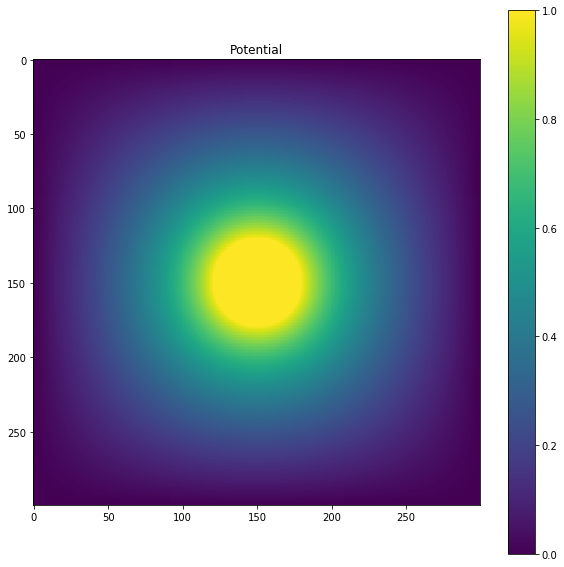

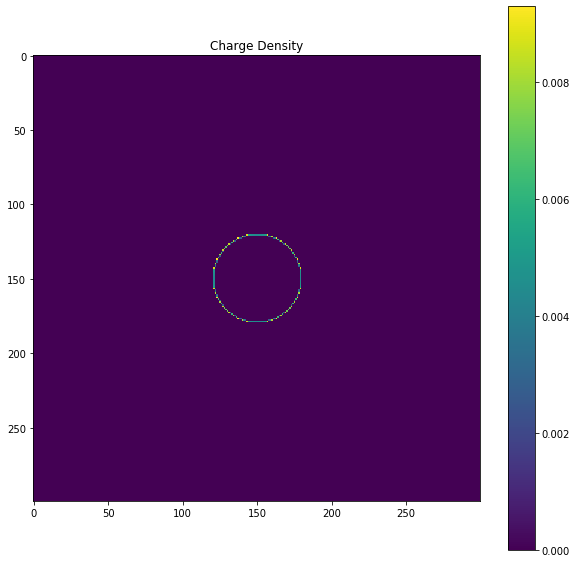

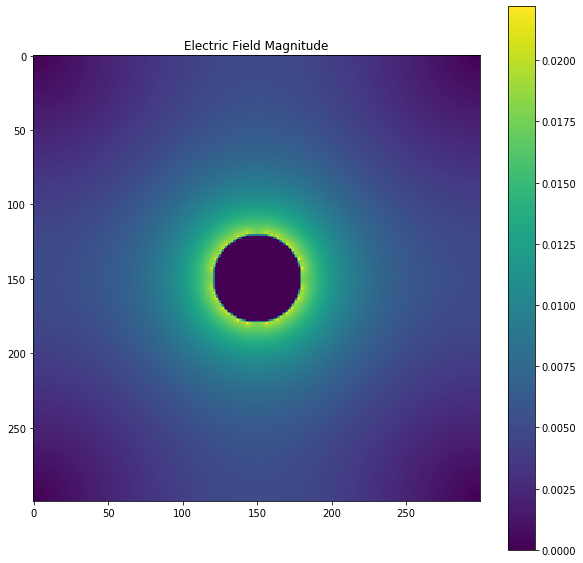

In [5]:
plt.figure(figsize = [10,10])
plt.imshow(V)
plt.colorbar()
plt.title('Potential')
plt.show()
plt.figure(figsize = [10,10])
plt.imshow(rho)
plt.colorbar()
plt.title('Charge Density')
plt.show()
plt.figure(figsize = [10,10])
plt.imshow(E_abs)
plt.colorbar()
plt.title('Electric Field Magnitude')
plt.show()

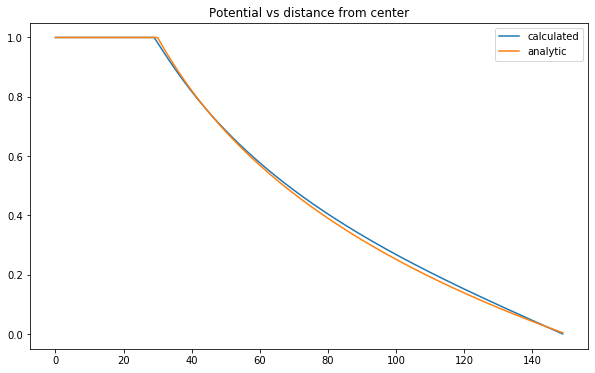

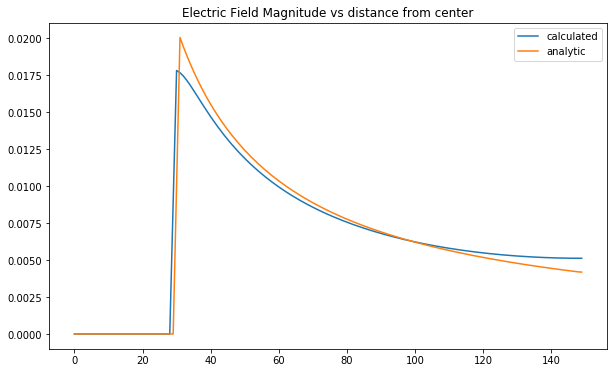

In [6]:
y = V[n//2][n//2:]
x = np.arange(n//2+n%2)
fit = np.zeros(len(x))
for i in x:
    if i < R:
        fit[i] = 1
    else:
        fit[i] = np.log(n/(2*i))/np.log(n/(2*R))

plt.figure(figsize = [10,6])
plt.plot(x,y,label='calculated');plt.plot(x,fit,label='analytic')
plt.title('Potential vs distance from center')
plt.legend()
plt.show()

plt.figure(figsize = [10,6])
plt.plot(x,np.abs(np.gradient(y)),label='calculated');plt.plot(x,np.abs(np.gradient(fit)),label='analytic')
plt.title('Electric Field Magnitude vs distance from center')
plt.legend()
plt.show()

As we can see, our potential and electric field are both very close to the analytic solution while all the charge is located on the edges of the cylinder, just as we would expect. However, note that as we predicted, there is overall a slight deviation from the analytic solution due to the fact that our box with potential zero is a square instead of a circle, which the analytic model assumes.

## Question 2

I will now modify the solver from question 1 to utilise conjugate gradient. First, I definine a function which will compute the laplacian for us, which is the "Ax" term in the conjugate gradient.

In [7]:
def Ax(V,mask):
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    return ans

Now, I will iteratively run the conjugate gradient alogrithm as shown in class. I will do so using the fact that our solution must obey $-\nabla^2 V = \rho / \epsilon_0$, and thus $(\nabla^2 V_0 -V_0)= \nabla^2 V$ at each step (where $V_0$ is equal to the boundary condition for $V$). I will compute the deviations from this equality (the residuals) $r = (\nabla^2 V_0 -V_0) - \nabla^2 V$ and use the conjugate gradient algorithm to minimise them at each step.

The most natural way to evaluate how well the conjugate gradient algorithm has converged is to check how small the squared sum of the residuals $r^T r =\sum r^2$ gets. However, since I am asked to compare it to the relaxation method, which does not prioritise minimising $\sum r^2$ particularly well, this is not a very good means of comparison in this case. 

Instead, for a more fair comparison, I will use the same convergence criteria as I did in Question 1 for the relaxation method, running the algorithm until $\Sigma (V_i-V_{i-1})^2$ drops below a certain threshold.

Using the same 300x300 grid and threshold of $\Sigma (V_i-V_{i-1})^2 < 10^{-8}$ as in Question 1, we get:

In [9]:
n=300
R = n/10

mask, bc = cylinder(n,R)
V=np.zeros([n,n])

b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
p=r.copy()
rtr=np.sum(r*r)
err = np.sum((V-bc)**2)

tol = 1e-8
nsteps=0

t1 = time.time()

while err > tol:
    V_old = V.copy()
    
    Ap=Ax(pad(p),mask)
    rtr=np.sum(r*r)
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew
    
    err=(np.sum(V-V_old)**2) 
    nsteps+=1
    

t2 = time.time()
deltat_conjgrad = t2-t1
print('steps taken:',nsteps)
print('elapsed time',deltat_conjgrad,'s')
print('This is',deltat_relax/deltat_conjgrad,'times faster than the relaxation method')

steps taken: 413
elapsed time 0.784224271774292 s
This is 43.64106740847147 times faster than the relaxation method


As we can see, the conjugate gradient method was over 40 times faster and needed a lot less steps to reach the same level of accuracy, a significant improvment!

## Question 3

To make it even faster, I will edit my algorithm such that it first starts with a smaller grid which it then upscales by a factor of 2 after reaching the desired accuracy, only to then run again on the new grid until it reaches the same accuracy once more, repeating the process as many times as needed. 

This is faster, because a lot less computation is needed on smaller grids, and so if we start with a potential that is already relatively accurate (since it reached the desired accuracy on the smaller grid), it doesn't need as many computations to reach the desired accuracy again on the larger grid. 

Thus, I will run the old algorithm on a 1600x1600 grid up to threshold of $\sum r^2 < 10^{-8}$ and then compare it to running the new algorithm on a 100x100 grid and upscaling it 4 times, ending up with the same 1600x1600 grid and the same degre of accuracy.

In [10]:
n=1600
R = n/10

mask, bc = cylinder(n,R)
V=np.zeros([n,n])
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
p=r.copy()
rtr=np.sum(r*r)

tol = 1e-8

t1 = time.time()

while rtr > tol:
    Ap=Ax(pad(p),mask)
    rtr=np.sum(r*r)
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew
    nsteps+=1
    
t2 = time.time()
deltat1 = t2-t1
print('elapsed time',deltat1,'s')

elapsed time 210.70912790298462 s


In [11]:
n=100
R = n/10

mask, bc = cylinder(n,R)
V=np.zeros([n,n])
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
rtr=np.sum(r*r)
p=r.copy()

levels=4
tol = 1e-8

t1=time.time()

while tol < rtr:
    Ap=(Ax(pad(p),mask))
    rtr=np.sum(r*r)
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew

for l in range(levels):
    n=n*2
    R=R*2
    V_coarse=V.copy()
    V=np.zeros([n,n])
    mask, bc= cylinder(n,R)
    
    V[::2,::2] = V_coarse
    V[1::2,::2] = V_coarse
    V[::2,1::2] = V_coarse
    V[1::2,1::2] = V_coarse
    
    b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    r=b-Ax(V,mask)
    rtr=np.sum(r*r)
    p=r.copy()
    while tol < rtr:
        Ap=(Ax(pad(p),mask))
        rtr=np.sum(r*r)
        alpha=rtr/np.sum(Ap*p)
        V=V+pad(alpha*p)
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/rtr
        p=rnew+beta*p
        r=rnew
        
t2=time.time()
deltat2 = t2-t1
print('elapsed time',deltat2,'s')
print('the new method is',deltat1/deltat2,'times faster')

elapsed time 55.587263345718384 s
the new method is 3.790600853877339 times faster


So, in the case of a 1600x1600 grid, it was almost 4 times faster, and we expect the difference to only grow larger for bigger grids.

Now that we have a much faster and more precise algorithm, let's re-do the plots from question 1 to see if they look better.

In [12]:
E = np.gradient(V)
E_abs = np.sqrt(E[0]**2+E[1]**2)
rho=pad(V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0)

lam_analytic = 2*np.pi/np.log(n/(2*R))
print('analytic lambda:',lam_analytic)

analytic lambda: 3.903962531662343


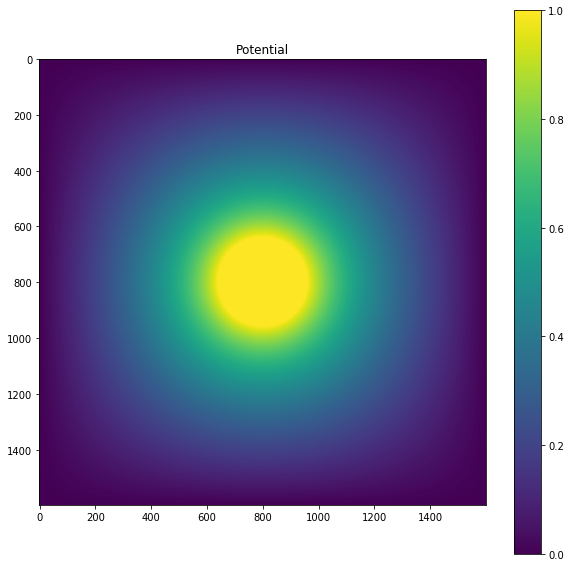

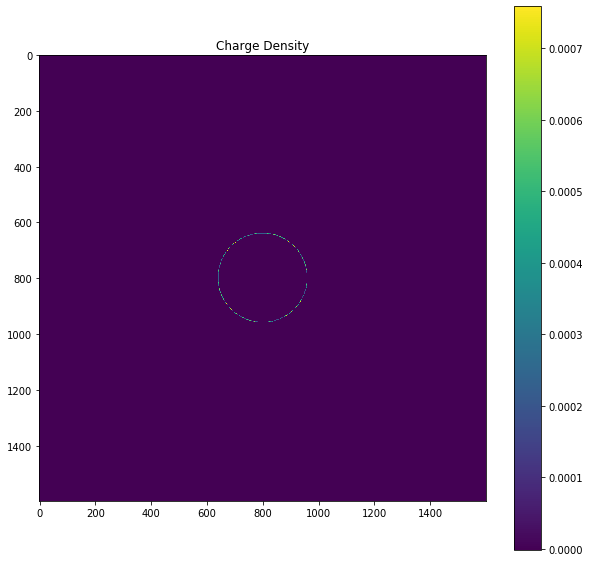

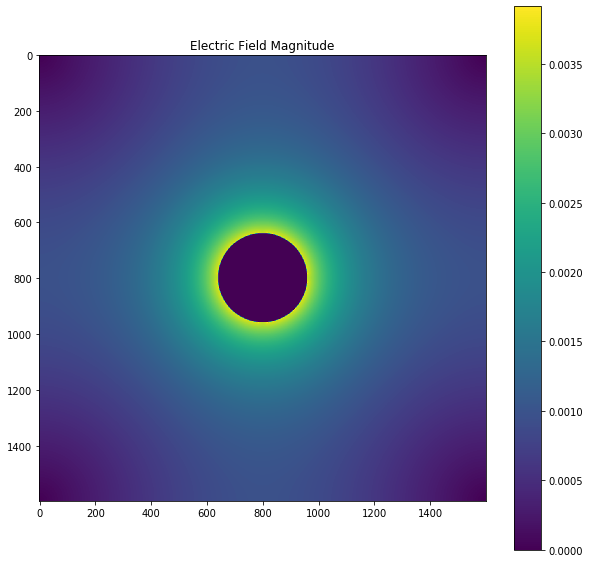

In [13]:
plt.figure(figsize = [10,10])
plt.imshow(V)
plt.colorbar()
plt.title('Potential')
plt.show()
plt.figure(figsize = [10,10])
plt.imshow(rho)
plt.colorbar()
plt.title('Charge Density')
plt.show()
plt.figure(figsize = [10,10])
plt.imshow(E_abs)
plt.colorbar()
plt.title('Electric Field Magnitude')
plt.show()

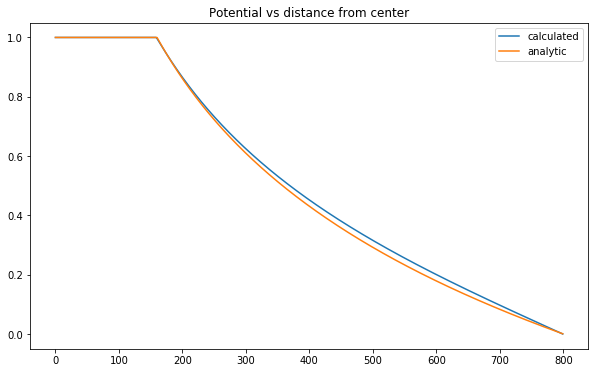

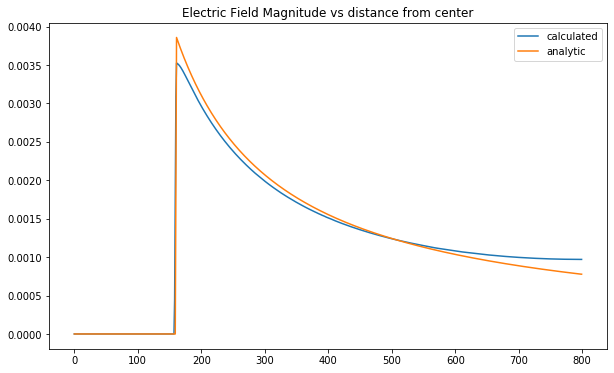

In [14]:
y = V[n//2][n//2:]
x = np.arange(n//2+n%2)
fit = np.zeros(len(x))
for i in x:
    if i < R:
        fit[i] = 1
    else:
        fit[i] = np.log(n/(2*i))/np.log(n/(2*R))

plt.figure(figsize = [10,6])
plt.plot(x,y,label='calculated');plt.plot(x,fit,label='analytic')
plt.title('Potential vs distance from center')
plt.legend()
plt.show()

plt.figure(figsize = [10,6])
plt.plot(x,np.abs(np.gradient(y)),label='calculated');plt.plot(x,np.abs(np.gradient(fit)),label='analytic')
plt.title('Electric Field Magnitude vs distance from center')
plt.legend()
plt.show()

These plots look much smoother than what we got in question 1 due to the higher resolution, but they are overall mostly the same

## Question 4

I will now modify my cylinder mask function to add a tiny circular bump centered on the surface of the right side of the cylinder with a radius 10 times smaller than the cylinder's. I will then re-run the algorithm from part 3 and look at what the new electric field looks like.

In [15]:
def cylinder_lump(n,R):
    bc = np.zeros([n,n])
    a = np.arange(n)
    i, j = np.meshgrid(a, a,indexing = 'ij')
    cylinder = (i-n//2)**2 +(j-n//2)**2 < R**2
    lump = (i-n//2)**2+(j-n//2-R)**2 < (R/10)**2
    bc[cylinder]=1.0
    bc[lump]=1.0
    mask = np.bool_(bc)
    mask[:,0]=True
    mask[:,-1]=True
    mask[0,:]=True
    mask[-1,:]=True
    return mask, bc

In [16]:
n=100
R = n/10

mask, bc = cylinder_lump(n,R)
V=np.zeros([n,n])
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
rtr=np.sum(r*r)
p=r.copy()

levels=4
tol = 1e-8

t1=time.time()

while tol < rtr:
    Ap=(Ax(pad(p),mask))
    rtr=np.sum(r*r)
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew

for l in range(levels):
    n=n*2
    R = R*2
    V_coarse=V.copy()
    V=np.zeros([n,n])
    mask, bc= cylinder_lump(n,R)
    
    V[::2,::2] = V_coarse
    V[1::2,::2] = V_coarse
    V[::2,1::2] = V_coarse
    V[1::2,1::2] = V_coarse
    
    b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    r=b-Ax(V,mask)
    rtr=np.sum(r*r)
    p=r.copy()
    while tol < rtr:
        Ap=(Ax(pad(p),mask))
        rtr=np.sum(r*r)
        alpha=rtr/np.sum(Ap*p)
        V=V+pad(alpha*p)
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/rtr
        p=rnew+beta*p
        r=rnew

print('elapsed time',time.time()-t1,'s')

elapsed time 54.91429424285889 s


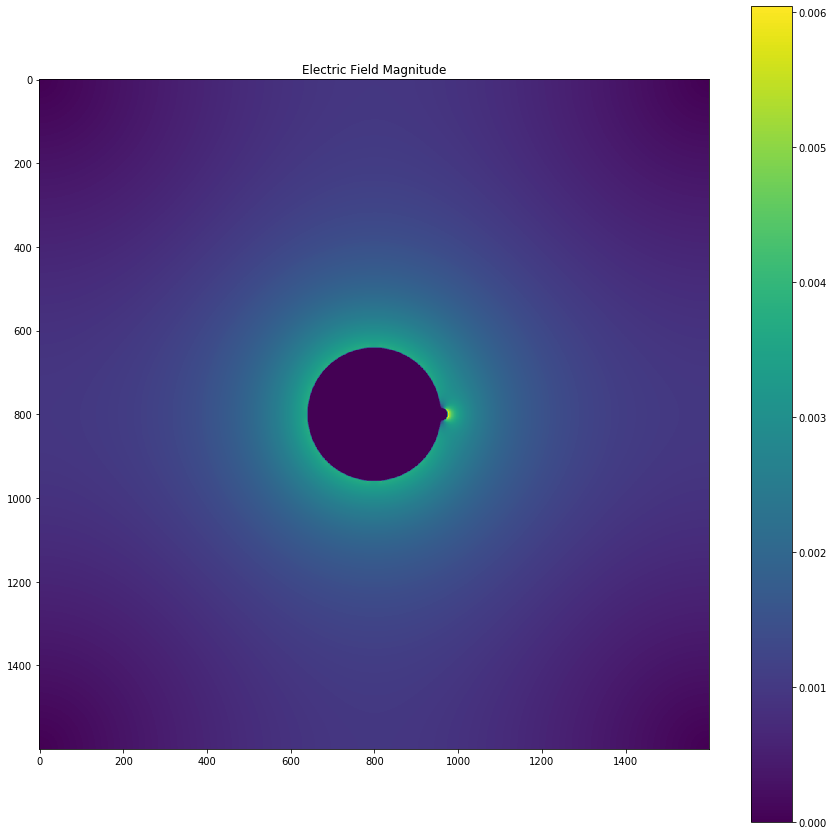

In [17]:
E = np.gradient(V)
E_abs = np.sqrt(E[0]**2+E[1]**2)

plt.figure(figsize = [15,15])
plt.imshow(E_abs)
plt.colorbar()
plt.title('Electric Field Magnitude')
plt.show()

We can see that the electric field is noticeably larger around the surface of the bump than on the surface of the rest of the cylinder. This indicates that the charge is bunched-up near the bump, which would lead to energy losses if this were a powerline, for example, as the surface current near the bump (and thus energy dissipated as heat) would be greater than if it were spread out evenly across the surface.

## Question 5

The heat equation is given by: $$\frac{\partial u}{\partial t}=\alpha \nabla^2 u$$ where $\alpha$ is a diffusion constant. 

It is similar to Poisson's equation, except the laplacian is equal to the function's time derivative. Thus, solving it is similar to what we previously did for the electric potential. First, note that we need a boundary condition, the most natural being the Neumann boundary condition: $\frac{\partial u}{\partial t}=0$ at the boundary (except for the wall we're heating of course). This guarantees that no heat "escapes" the system as it reaches the boundary, instead getting reflected back.

Note that since no heat is lost in the borders, and that the temperature gradient is initially perpendicular to the border which is being heated, then the temperature can only increase in the direction perpendicular to the border being heated. Thus, this really reduces to a one-dimentional problem and is equivalent to that of heating a rod at one of its tips.

In one dimention, the heat equation becomes: $$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

Discretising this, we obtain:
$$\frac{u(x,t+\Delta t) - u(x,t)}{\Delta t} = \alpha\frac{u(x-\Delta x,t) + u(x+\Delta x,t) - 2u(x,t)}{(\Delta x)^2}$$
and thus
$$u(x,t+\Delta t) = u(x,t)+ \frac{\alpha \Delta t}{(\Delta x)^2} \left( u(x-\Delta x,t) + u(x+\Delta x,t) - 2u(x,t) \right)$$

I will use this iteratively to evolve the temperature of the box over time and space simultaneously.

Since we are not dealing with $\frac{\Delta t}{(\Delta x)}$ we can't make use of the CFL condition directly. However, some quick fourrier analysis similar to what we did in-class reveals that the system is stable provided $r = \frac{\alpha \Delta t}{(\Delta x)^2}<\frac{1}{2}$

I will now write a function which animates a plot over time of the temperature along the middle of the nxn box. It will require the box size, time and space steps, box conductivity $\alpha$, total elapsed time, and the rate at which the edge increases in temperature as inputs. At each time step, it will iteratively enforce the boundary condition and then apply the discrete 1d diffusion equation.

Note that the far-edge can only receive temperature from one side, since the neumann boundary condition implies $\frac{\partial u(x_b)}{\partial t}=0$. Thus, the double discrete spatial derivative turns into a single discrete spatial derivative at the boundary, and so we get $u(x_b,t+\Delta t) = u(x_b,t)+ \frac{\alpha \Delta t}{(\Delta x)^2} \left(u(x_b-\Delta x,t) - u(x_b,t) \right)$.

In [18]:
def Temp(n,dt,dx,alpha,t_final,dT_edge):
    x = np.arange(0,n,dx)
    t = np.arange(0,t_final+dt,dt)
    T_edge = t*dT_edge
    T = np.zeros([len(t),len(x)])
    r = alpha*dt/dx**2
    for i in range(len(t)-1):
        for j in range(1,len(x)-1):
            T[i,0] = T_edge[i]
            T[i+1,j] = T[i,j] + r*(T[i,j-1] + T[i,j+1] - 2*T[i,j])
            T[i+1,-1]= T[i,-1] + r*(T[i,j-1] - T[i,j])
        clear_output(wait = True)
        plt.figure(figsize = [12,7])
        plt.ylim(top=1.1*T_edge[-1])
        plt.plot(x,T[i])
        plt.title('Temperature along the middle')
        plt.show()
        plt.pause(0.001)

First, let's demonstrate the stability condition, I will pick variables which end up giving an r value of 0.55, just above what would otherwise be considered stable. What could possibly happen?

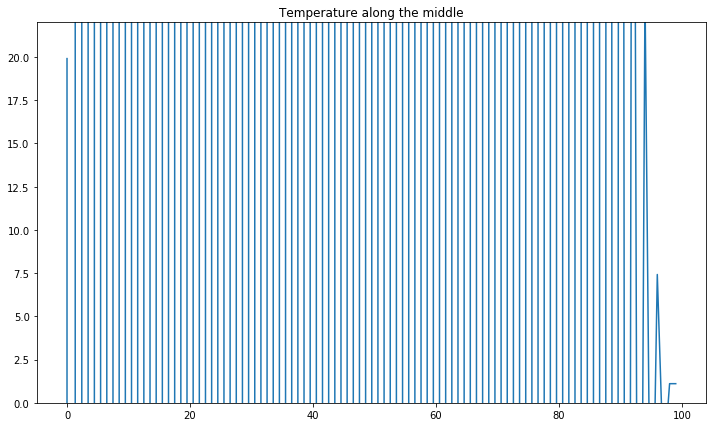

elapsed time 19.95430612564087 s


In [22]:
t = time.time()
Temp(100,0.1,1,5.5,20,1)
print('elapsed time',time.time()-t,'s')

It started out decent but quickly exploded, so clearly, the stability condition must be obeyed if we want to obtain meaningful results

Let's now try running it for a 1000x1000 box with a low conductivity for 10 time units with an edge temperature increasing at a rate of 10 units per second, making sure r is below 0.5

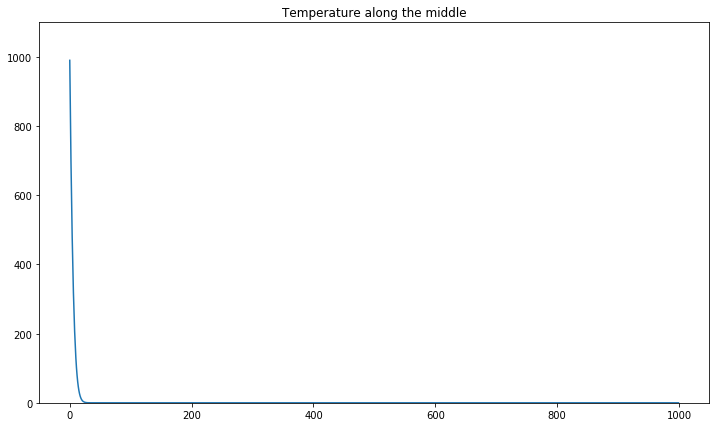

elapsed time 9.331508874893188 s


In [20]:
t = time.time()
Temp(1000,1,1,0.45,100,10)
print('elapsed time',time.time()-t,'s')

As we can see, the temperature is very sharply peaked near the heated boundary and does not seem to have changed much anywhere else

Now, let's run it for a much longer time in a box with better conductivity. This is much slower to compute, and so I will decrease the size of the box down to 20x20 to speed things up

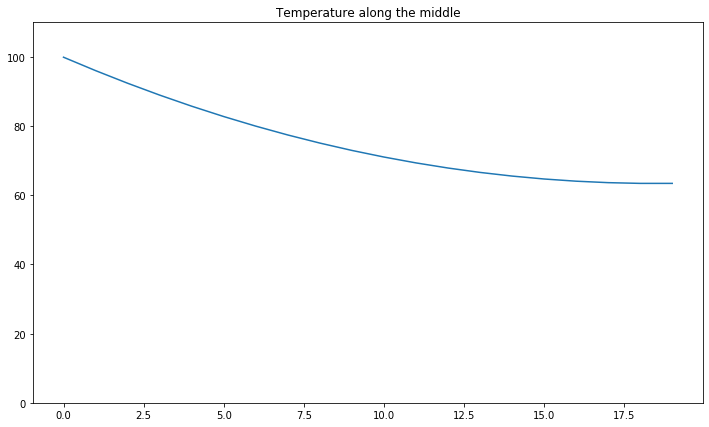

elapsed time 95.30722951889038 s


In [21]:
t = time.time()
Temp(20,0.01,1,45,10,10)
print('elapsed time',time.time()-t,'s')

As we can see,the left side is still a bit hotter, but overall, the temperature is a lot more spread out. In the limiting case, this would be perfectly flat, but that would take a very long time to compute.

These perfectly examplify the two regimes of the system:

The "isolating" regime is when the edge heats up much faster than the box can absorb heat, and thus the edge gets very hot while the rest of the box's temperature remains relatively is unchanged

The "conductive" regime is when the temperature on the edge increases slowly enough for the heat to spread throughout the box and reach something close to a state of equilibrium